<a href="https://colab.research.google.com/github/djbradyAtOpticalSciencesArizona/computationalImaging/blob/master/rays/cassi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Coded Aperture Snapshot Spectral Imaging
###David Brady
### University of Arizona

### Xin Yuan and Zongliang Wu
### Westlake University

Section 4.5 of **Computational Imaging**

This notebook simulates TV and neural estimation of a CASSI measurement of the x$\lambda$ plane. We set up multframe sampling with a randomly coded forward model. 

### Python modules

In [35]:
import numpy as np
import matplotlib.pyplot as plt
# from google.colab import files
from scipy import signal, io
from scipy import integrate
from scipy.linalg import toeplitz
import cv2
%matplotlib inline
plt.rcParams['figure.figsize'] = [30, 10]
plt.rcParams.update({'font.size': 22})
from google.colab import files
import sys


In [37]:
pwd

'/content'

In [ ]:
files.upload()

In [ ]:
!unzip Unet2D.zip

In [38]:
sys.path.append('/content/Unet2D')

In [2]:
!pip install pylops
import pylops

     |████████████████████████████████| 183 kB 8.7 MB/s 


## Forward Model

here we consider a simple example of 2D coded aperture snapshot spectral imaging. We image the $x\lambda $ plane. 

As an example, we use the Indian Pines data set described by

Baumgardner, M. F., Biehl, L. L., Landgrebe, D. A. (2015). 220 Band AVIRIS Hyperspectral Image Data Set: June 12, 1992 Indian Pine Test Site 3. Purdue University Research Repository. [doi:10.4231/R7RX991C](https://purr.purdue.edu/publications/1947/1)

The data is 2900 meters by 2900 meters with an approximate ground sample distance of 20 meters. There are 220 spectral bands spanning 400 to 2400 nm, the image captures various crops and forests. 



In [39]:
!wget http://www.ehu.eus/ccwintco/uploads/2/22/Indian_pines.mat
pip=io.loadmat('Indian_pines.mat')
data=pip['indian_pines']

--2021-11-24 01:40:47--  http://www.ehu.eus/ccwintco/uploads/2/22/Indian_pines.mat
Resolving www.ehu.eus (www.ehu.eus)... 158.227.0.65, 2001:720:1410::65
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6296374 (6.0M)
Saving to: ‘Indian_pines.mat.2’

Indian_pines.mat.2  100%[===================>]   6.00M   633KB/s    in 11s     

2021-11-24 01:40:58 (585 KB/s) - ‘Indian_pines.mat.2’ saved [6296374/6296374]



# Spatial View of the data set

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

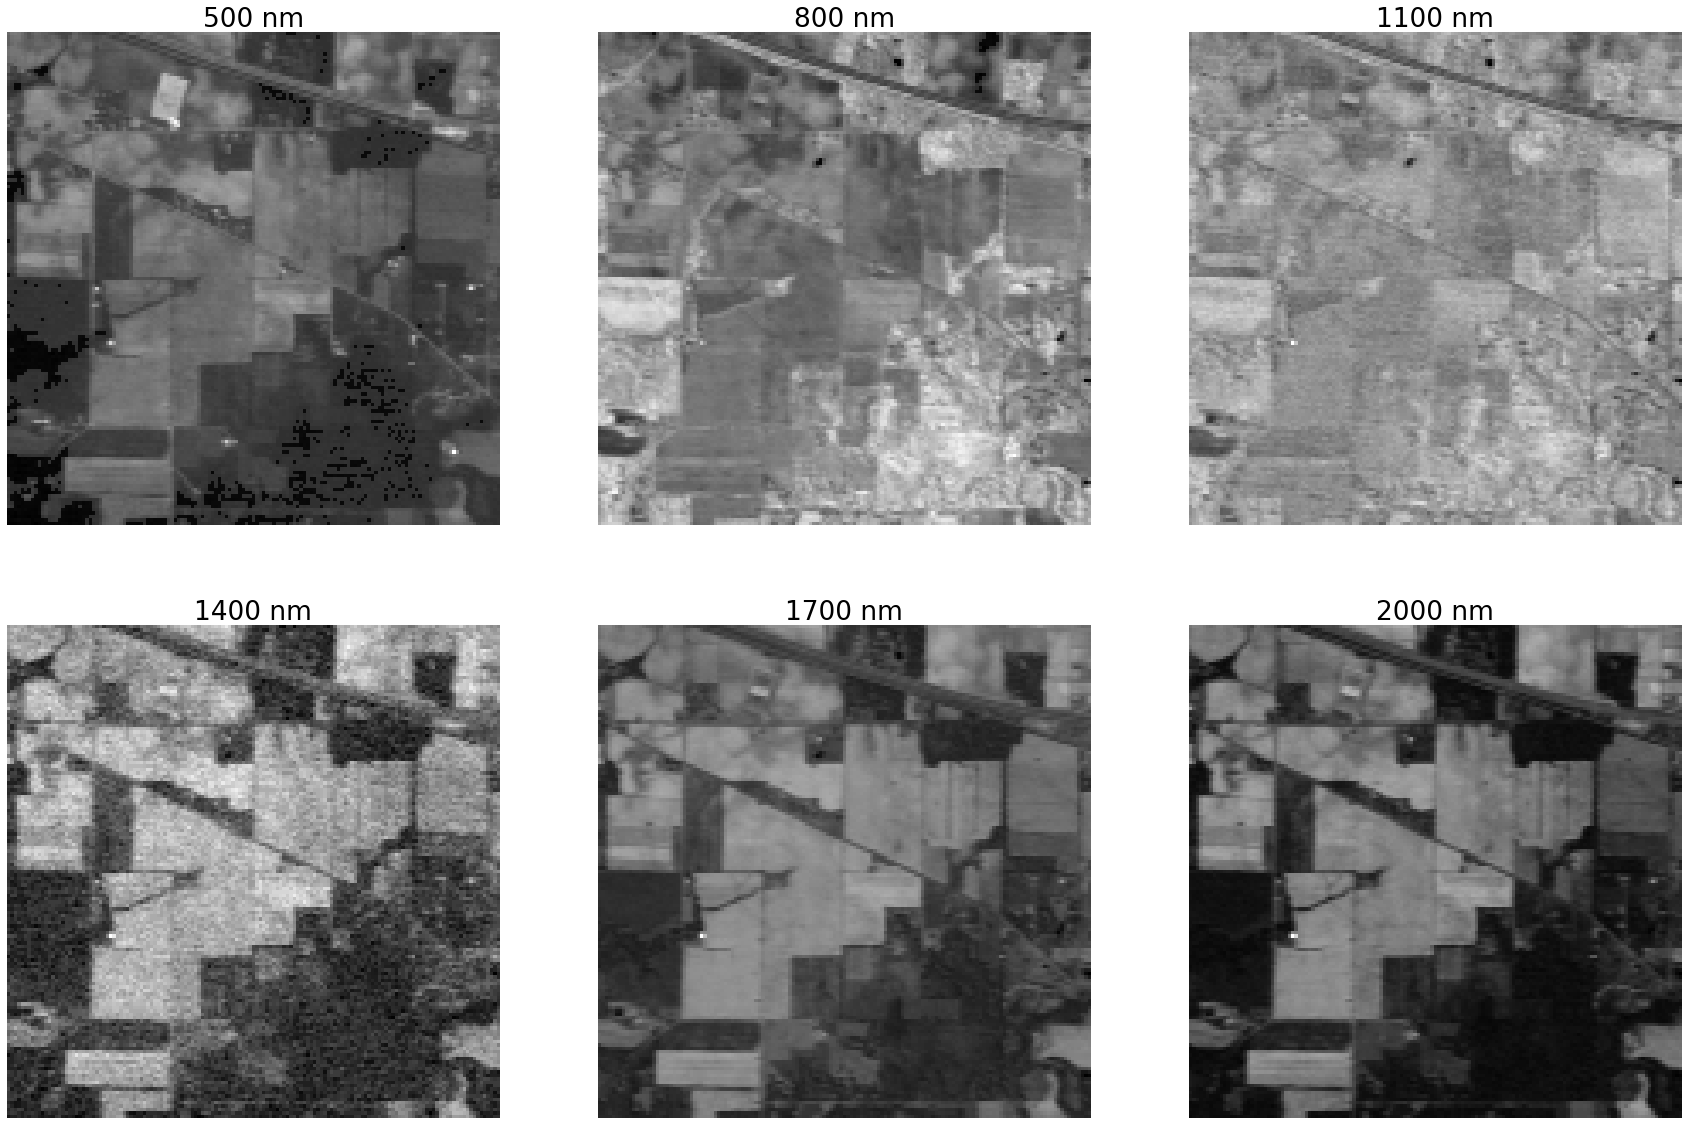

In [16]:


plt.rcParams['figure.figsize'] = [30, 20]
plt.subplot(2,3,1)
plt.imshow(data[:,:,11], extent=[0,2900,0,2900], cmap='gray')
plt.axis('off')
plt.title('500 nm')
plt.subplot(2,3,2)
plt.imshow(data[:,:,44], extent=[0,2900,0,2900], cmap='gray')
plt.axis('off')
plt.title('800 nm')
plt.subplot(2,3,3)
plt.imshow(data[:,:,77], extent=[0,2900,0,2900], cmap='gray')
plt.axis('off')
plt.title('1100 nm')
plt.subplot(2,3,4)
plt.imshow(data[:,:,110], extent=[0,2900,0,2900], cmap='gray')
plt.axis('off')
plt.title('1400 nm')
plt.subplot(2,3,5)
plt.imshow(data[:,:,143], extent=[0,2900,0,2900], cmap='gray')
plt.axis('off')
plt.title('1700 nm')
plt.subplot(2,3,6)
plt.imshow(data[:,:,176], extent=[0,2900,0,2900], cmap='gray')
plt.axis('off')
plt.title('2000 nm')

plt.savefig('indianPinesSpatial.pdf')
files.download('indianPinesSpatial.pdf')

## Spectral view of data set

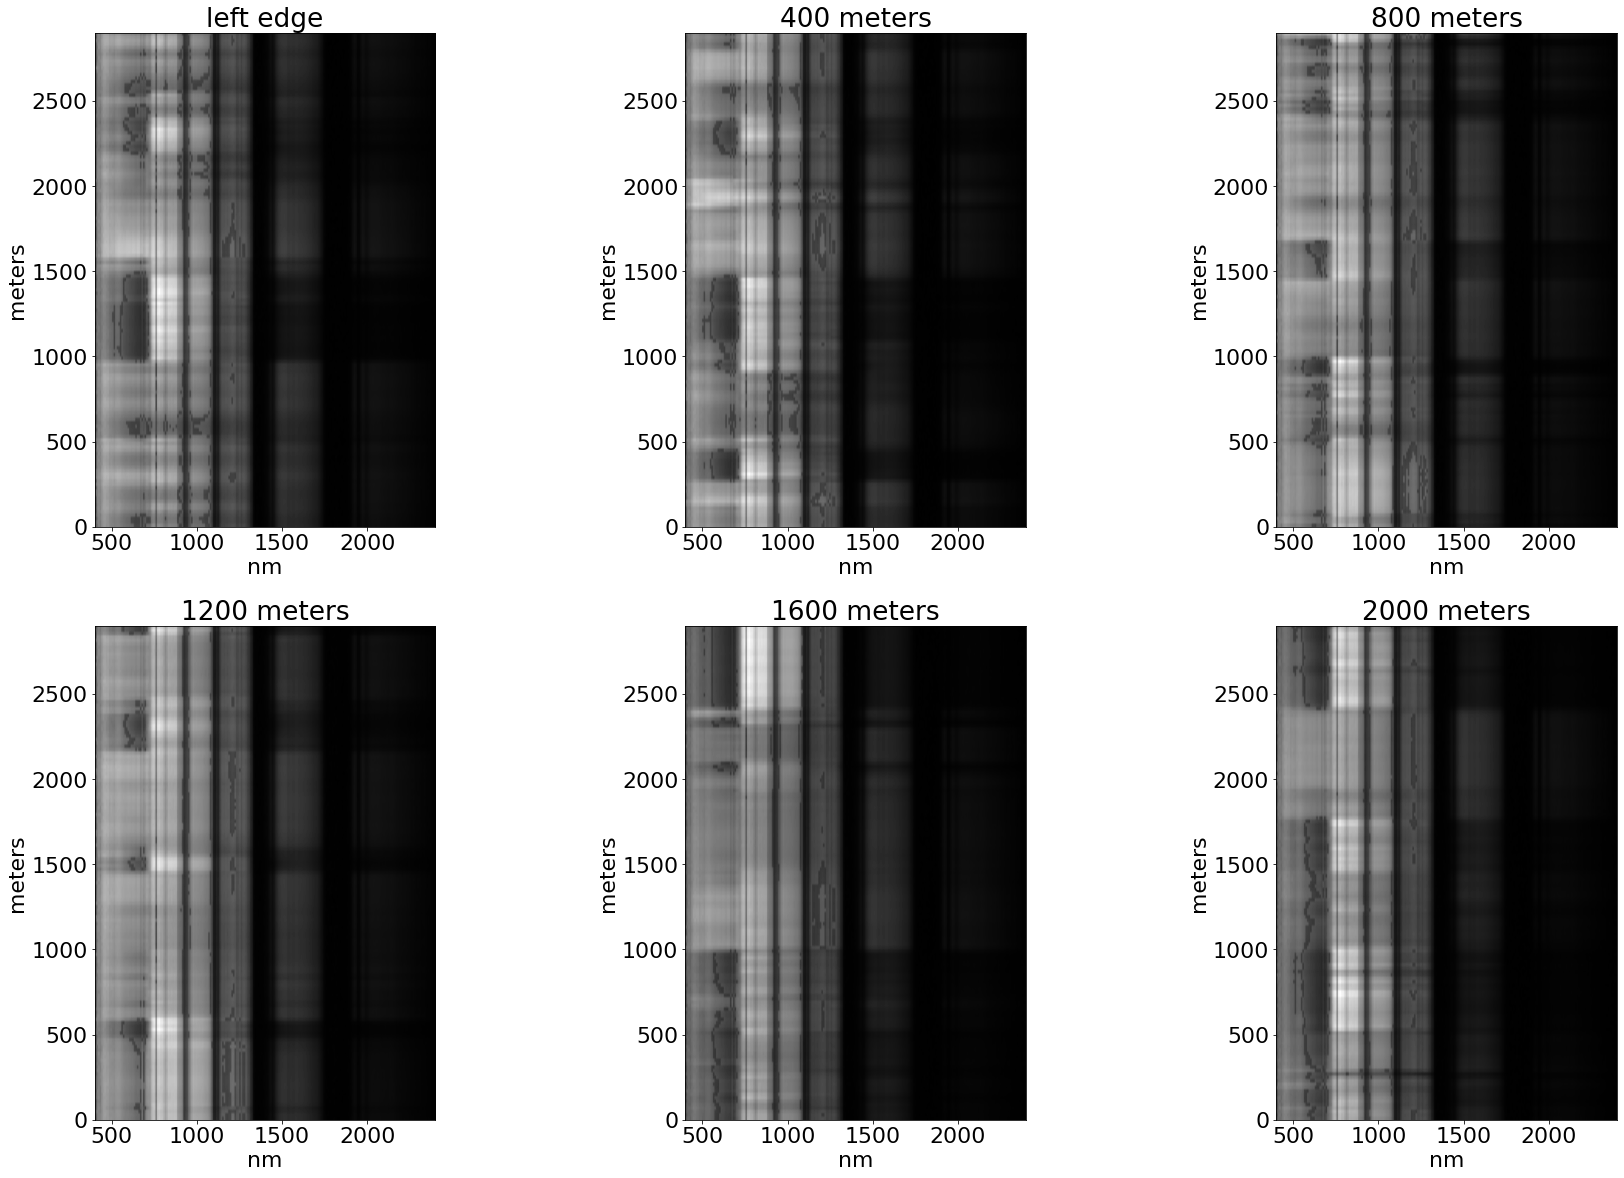

In [17]:
plt.rcParams['figure.figsize'] = [30, 20]
plt.subplot(2,3,1)
plt.imshow(data[0,:,:], extent=[400,2400,0,2900], cmap='gray')
plt.xlabel('nm')
plt.ylabel('meters')
plt.title('left edge')
plt.subplot(2,3,2)
plt.imshow(data[20,:,:], extent=[400,2400,0,2900], cmap='gray')
plt.xlabel('nm')
plt.ylabel('meters')
plt.title('400 meters')
plt.subplot(2,3,3)
plt.imshow(data[40,:,:], extent=[400,2400,0,2900], cmap='gray')
plt.xlabel('nm')
plt.ylabel('meters')
plt.title('800 meters')
plt.subplot(2,3,4)
plt.imshow(data[60,:,:], extent=[400,2400,0,2900], cmap='gray')
plt.xlabel('nm')
plt.ylabel('meters')
plt.title('1200 meters')
plt.subplot(2,3,5)
plt.imshow(data[80,:,:], extent=[400,2400,0,2900], cmap='gray')
plt.xlabel('nm')
plt.ylabel('meters')
plt.title('1600 meters')
plt.subplot(2,3,6)
plt.imshow(data[100,:,:], extent=[400,2400,0,2900], cmap='gray')
plt.xlabel('nm')
plt.ylabel('meters')
plt.title('2000 meters')

plt.savefig('indianPinesSpectral.pdf')
#files.download('indianPinesSpectral.pdf')

Rather than attempt to reconstruct all 220 spectral bands, we consider a 64 band subset 

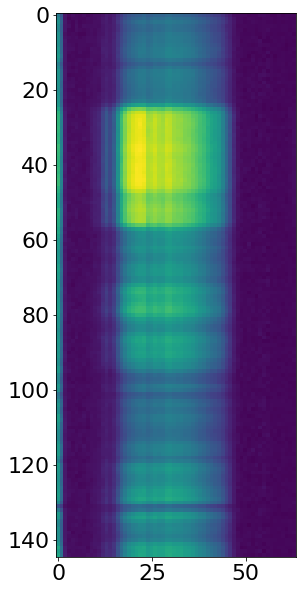

In [40]:
Nl=64
x = data[100,:,100:(100+Nl)]
x = cv2.resize(x, (Nl,145), interpolation = cv2.INTER_AREA)
x = x/x.max()
ny, nx = x.shape
plt.imshow(x)

## Measurement with a coded aperture

With a coded aperture spectral imager, the scene is first imaged  on to a code and then sheared by a dispersive element before measurement. Here the scene has 145 spatial pixels, so the code will also have 145 pixels. 

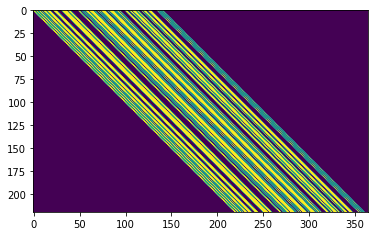

In [ ]:
code=np.random.randint(0,2,145)
r=np.zeros(220+145)
r[0:145]=code
c=np.zeros(220)
c[0]=r[0]
H=toeplitz(c,r)
plt.imshow(H)

First measurement is spatial element one, spectral element 1 multiplied by code element one. Second meaurement is x2 s1 t2 + x1 s2 t1. third is x3 s1 t3 + x2 t2 s2 + x1 t1 s3


for Nl spectral channels and Nx spatial channels, assume one pixel shift in the spatial channels in each measurement. The measurement matrix is a $Nl\times Nx$ by $Nl+Nx$ matrix. Let the plane be rastered in Nl elements each Nx elements long. The code multiplies the each of the Nx elements. Then one element is taken from each of the spectral bands in a shifting form.
$$g_n=\sum_{i=0}^{n} S_{i,n-i}t_{n-i}$$
or $h_{ij}=0$ except
$$h_{n,i*n-i}=t_{n-i}$$
To reduce the compression ratio, we may take multiple measurements with different random codes.


In [ ]:
Nl=64
Nx=145
H=np.zeros((Nl+Nx,Nl*Nx))
for l in range(1,Nl+Nx+1):
  for ll in range(np.maximum(l-Nx,0),np.minimum(l,Nl)):
    H[l,ll*Nx+l-ll-1]=code[l-ll-1]

code1=np.random.randint(0,2,145)
H1=np.zeros((Nl+Nx,Nl*Nx))
for l in range(1,Nl+Nx+1):
  for ll in range(np.maximum(l-Nx,0),np.minimum(l,Nl)):
    H1[l,ll*Nx+l-ll-1]=code1[l-ll-1]
H=np.vstack((H,H1))


code1=np.random.randint(0,2,145)
H1=np.zeros((Nl+Nx,Nl*Nx))
for l in range(1,Nl+Nx+1):
  for ll in range(np.maximum(l-Nx,0),np.minimum(l,Nl)):
    H1[l,ll*Nx+l-ll-1]=code1[l-ll-1]
H=np.vstack((H,H1))


code1=np.random.randint(0,2,145)
H1=np.zeros((Nl+Nx,Nl*Nx))
for l in range(1,Nl+Nx+1):
  for ll in range(np.maximum(l-Nx,0),np.minimum(l,Nl)):
    H1[l,ll*Nx+l-ll-1]=code1[l-ll-1]
H=np.vstack((H,H1))
H=np.vstack((H,H1))

code1=np.random.randint(0,2,145)
H1=np.zeros((Nl+Nx,Nl*Nx))
for l in range(1,Nl+Nx+1):
  for ll in range(np.maximum(l-Nx,0),np.minimum(l,Nl)):
    H1[l,ll*Nx+l-ll-1]=code1[l-ll-1]
H=np.vstack((H,H1))







## Total Variation Inversion

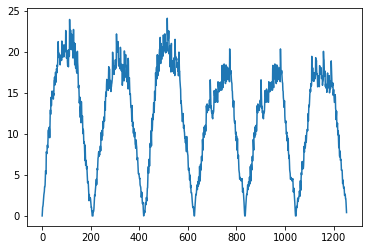

In [ ]:
n = np.random.normal(0, 0., (ny, nx))
y = np.matmul(H,(x.flatten()+n.flatten()))

plt.plot(y)

(-0.5, 63.5, 144.5, -0.5)

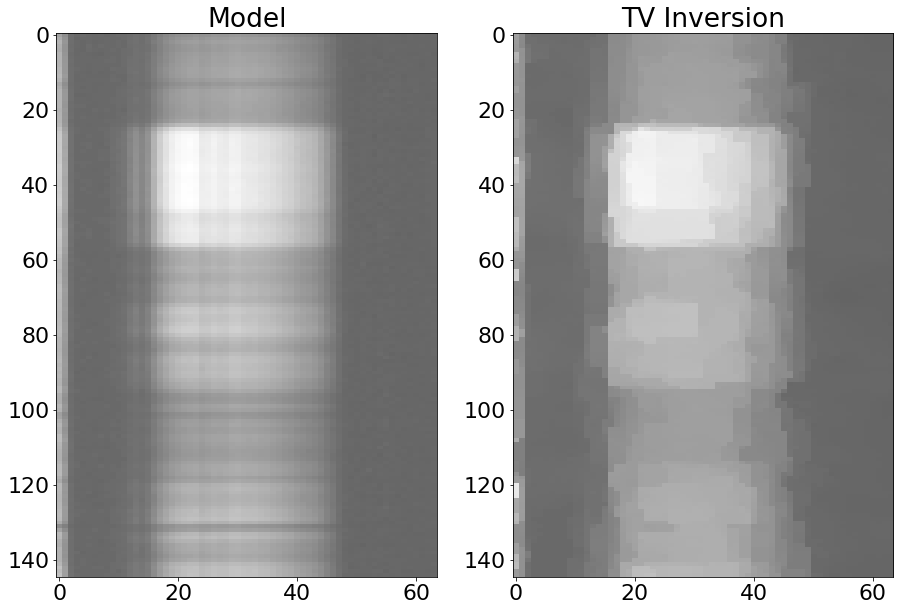

In [41]:
# for different 'H', please refer 'readme_for_CASSI.txt'.


#io.savemat('input.mat',{'H':H,
#                        'y':y})

inputs = io.loadmat('./Unet2D/input.mat')
H = inputs['H']
y = inputs['y'][0,:]


import pylops

Dop = \
    [pylops.FirstDerivative(ny * nx, dims=(ny, nx), dir=0, edge=False,
                            kind='backward'),
     pylops.FirstDerivative(ny * nx, dims=(ny, nx), dir=1, edge=False,
                            kind='backward')]


# TV
mu = .5
lamda = [.1, .1]
niter = 30
niterinner = 10


xinv, niter = \
    pylops.optimization.sparsity.SplitBregman(H, Dop, y,
                                              niter, niterinner,
                                              mu=mu, epsRL1s=lamda,
                                              tol=1e-4, tau=1., show=False,
                                              **dict(iter_lim=5, damp=1e-4))
xinv = np.real(xinv.reshape(ny, nx))

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
axs[0].imshow(x, vmin=0, vmax=1, cmap='gray')
axs[0].set_title('Model')
axs[0].axis('tight')
axs[1].imshow(xinv, vmin=0, vmax=1, cmap='gray')
axs[1].set_title('TV Inversion')
axs[1].axis('tight')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

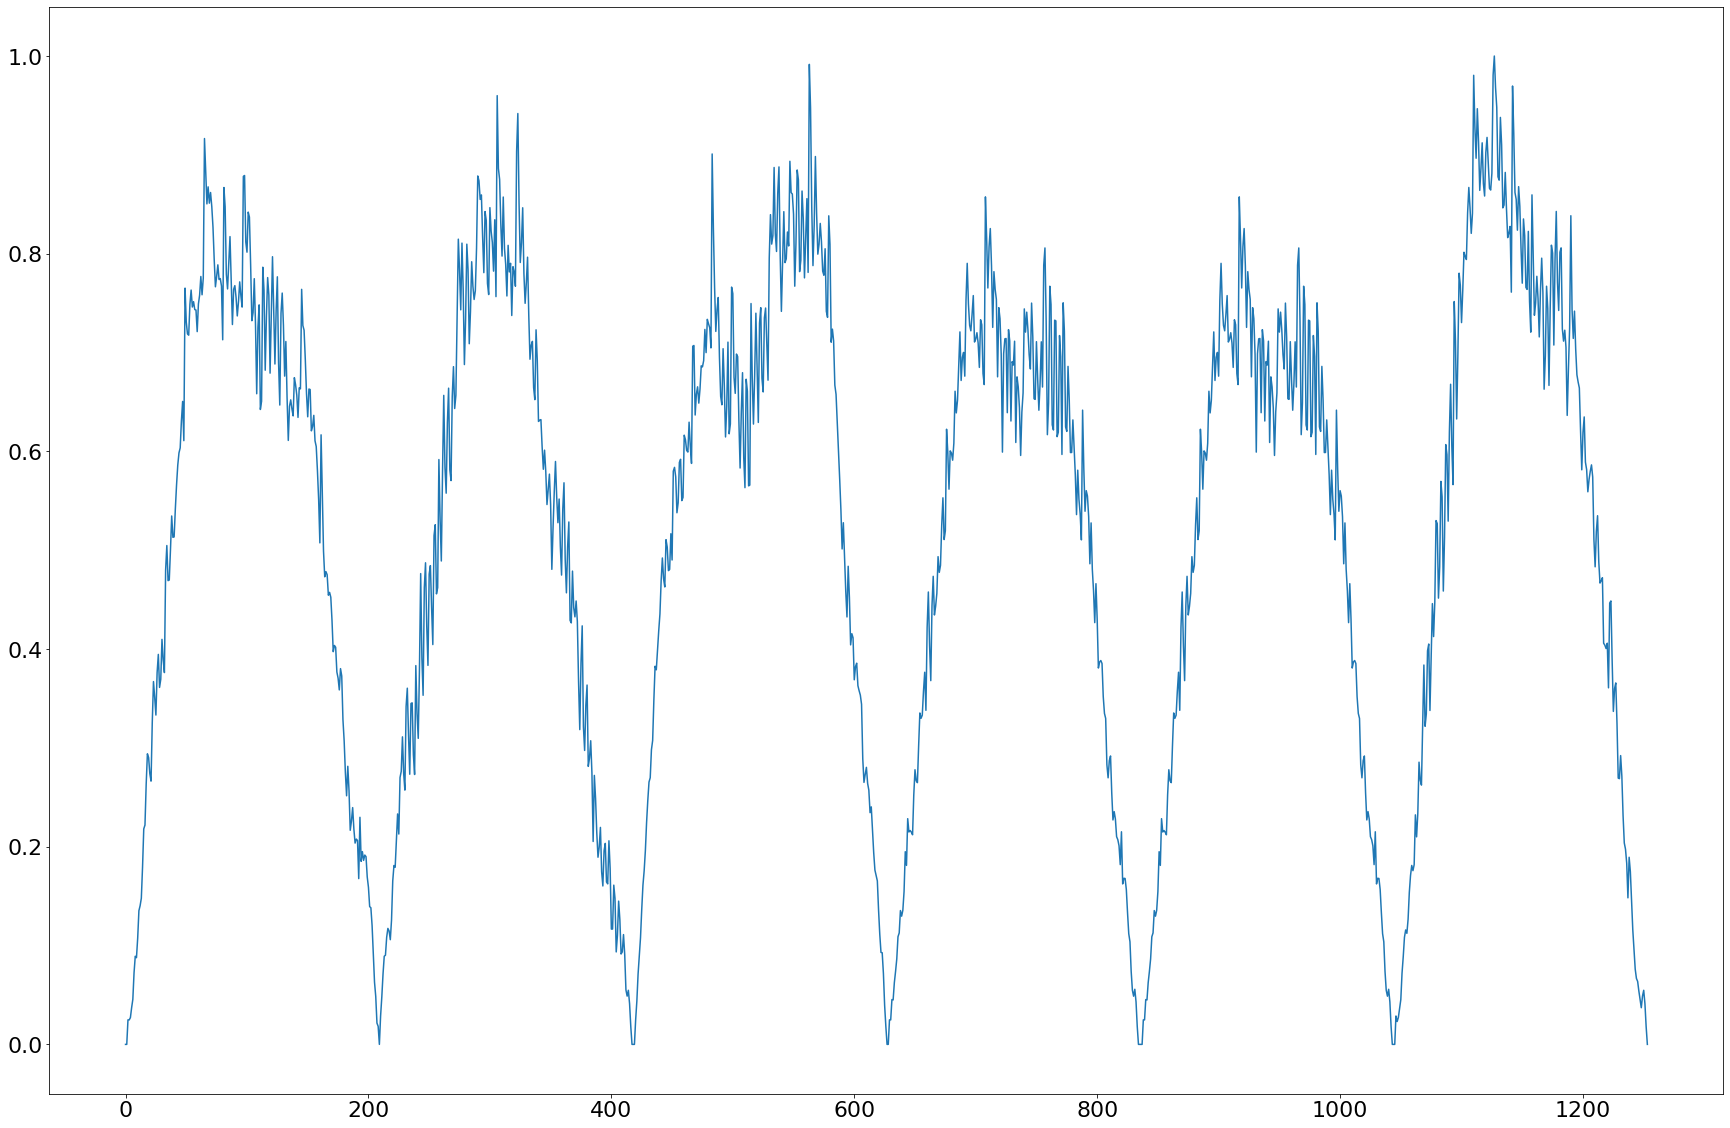

In [19]:
plt.plot(y/np.max(y))
plt.savefig('indianPinesMeasurements.pdf')
files.download('indianPinesMeasurements.pdf')

## U-net reconstruction

In [42]:

import numpy as np
import torch
import torch.utils
import scipy.io as io
from Unet2D.model_Unet import  UNet
from Unet2D.train_unet import random_choose,gen_HTy
import imageio

def infer(data_test, model,H=None):
    test_gt = random_choose(data_test, 1)
    yHT = gen_HTy(test_gt,H).float().cuda()
    test_gt = test_gt.cuda()
    model_out = model(yHT)
    return model_out

(144, 145, 64)
torch.Size([104, 145, 64])
torch.Size([10, 145, 64])
torch.Size([104, 1254])


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [43]:
# load pre-trained model
model = UNet(1,1) #A simple 3 layer Unet with some residual blocks
model_dict = torch.load('./Unet2D/net40.pth')
model.load_state_dict(model_dict)
model.cuda()
# infer
x_torch = torch.from_numpy(x)
x_torch = x_torch.unsqueeze(0)
x_recon_Unet = infer(x_torch, model,H=H)
x_recon_Unet = x_recon_Unet.squeeze(0)
x_recon_Unet = x_recon_Unet.cpu().detach().numpy()
print(x_recon_Unet.max())
x_recon_Unet = x_recon_Unet/x_recon_Unet.max()

1.0449891


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

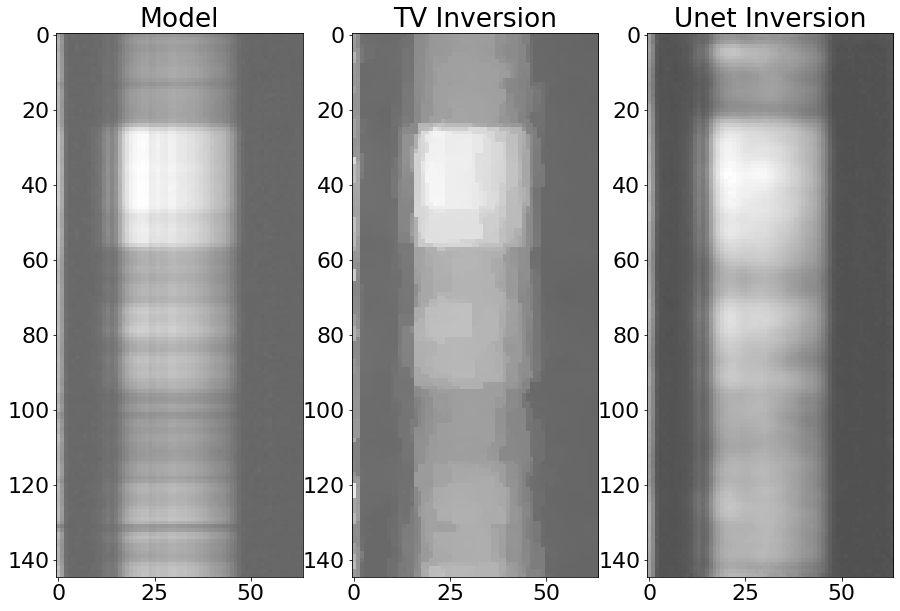

In [44]:
fig, axs = plt.subplots(1, 3, figsize=(15, 10))
axs[0].imshow(x, vmin=0, vmax=1, cmap='gray')
axs[0].set_title('Model')
axs[0].axis('tight')
axs[1].imshow(xinv, vmin=0, vmax=1, cmap='gray')
axs[1].set_title('TV Inversion')
axs[1].axis('tight')
axs[2].imshow(x_recon_Unet, vmin=0, vmax=1, cmap='gray')
axs[2].set_title('Unet Inversion')
axs[2].axis('tight')
plt.savefig('indianPinesReconstruction.pdf')
files.download('indianPinesReconstruction.pdf')


Archive:  Unet2D.zip
   creating: Unet2D/__pycache__/
  inflating: Unet2D/__pycache__/model_Unet.cpython-38.pyc  
  inflating: Unet2D/__pycache__/ssim_torch.cpython-38.pyc  
  inflating: Unet2D/__pycache__/utilts.cpython-38.pyc  
  inflating: Unet2D/input.mat        
  inflating: Unet2D/model_Unet.py    
  inflating: Unet2D/net40.pth        
  inflating: Unet2D/ssim_torch.py    
  inflating: Unet2D/train_unet.py    
  inflating: Unet2D/utilts.py        
